In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
import os
os.chdir('c:\\Users\\Ido\\My Drive\\R\\Workshop-Reinforcement-Learning-Modeling-For-Human-Choice-Behavior')

In [32]:
#set initial var
Narms              = 2
Nstates            = 2
Nblocks            = 20
Ntrials            = 100
data = pd.read_csv('data/stanmodel_two_step_task/artificial_data.csv')
choices1 = data['choice1'].to_numpy()
choices2 = data['choice2'].to_numpy()
states = data['state'].to_numpy()
rewards = data['reward'].to_numpy()
state_transition = np.array([[0.7, 0.3], [0.3, 0.7]])
alpha = 0.3
lambda_ = 0.5
beta = 3
omegas = np.arange(0,1,0.1)

In [38]:
#for each parameter combination, get probability of choosing the action that was chosen
all_likelihoods = []

for omega in omegas:
    log_likelihood = []

    for block in range(Nblocks):
    # initialize Qmf values on each block
        Qmf1 = np.full(Narms, 0.5) # stage 1 - only one state
        Qmf2 = np.full((Nstates, Narms), 0.5) # stage 2 - two states
        # initialize Qmb values - only for first stage - second stage is identical to MF
        Qmb1 = np.full(Narms, 0.5)
        for trial in range(Ntrials):
            Qmb1[0] = state_transition[0, 0] * max(Qmf2[0, :]) + state_transition[1, 0] * max(Qmf2[1, :])
            Qmb1[1] = state_transition[0, 1] * max(Qmf2[0, :]) + state_transition[1, 1] * max(Qmf2[1, :])
            # integrate MF and MB values modulated by omega parameter
            Qnet1 = omega * Qmb1 + (1 - omega) * Qmf1
            #players choice probabilities
            p1 = np.exp(beta * Qnet1) / np.sum(np.exp(beta * Qnet1))
            choice1 = choices1[trial] - 1
            log_likelihood.append(np.log(p1[choice1]))

            #updating Qvalues
            reward = rewards[trial]
            # updating Qmf values
            state = states[trial]-1
            choice2 = choices2[trial] - 1
            p2 = np.exp(beta * Qmf2[state, :]) / np.sum(np.exp(beta* Qmf2[state, :]))
            #log_likelihood.append(np.log(p2[choice2]))
            # Prediction errors
            PE2 = reward - Qmf2[state, choice2] # second stage reward-based prediction error
            PE1 = Qmf2[state, choice2] - Qmf1[choice1] # first stage prediction error
            
            # second stage update
            Qmf2[state, choice2] = Qmf2[state, choice2] + alpha * PE2
            # first stage update with an eligibility trace for the second-stage prediction error
            Qmf1[choice1] = Qmf1[choice1] + alpha * PE1 + lambda_ * alpha * PE2
    
    all_likelihoods.append(np.sum(log_likelihood))    

In [39]:
np.shape(all_likelihoods)
all_likelihoods

[-615.5486601265991,
 -617.5359568949286,
 -620.1150596212101,
 -623.3003012262939,
 -627.1051143577116,
 -631.5419059670025,
 -636.6219361584714,
 -642.3552038261905,
 -648.7503416065176,
 -655.8145225899809]

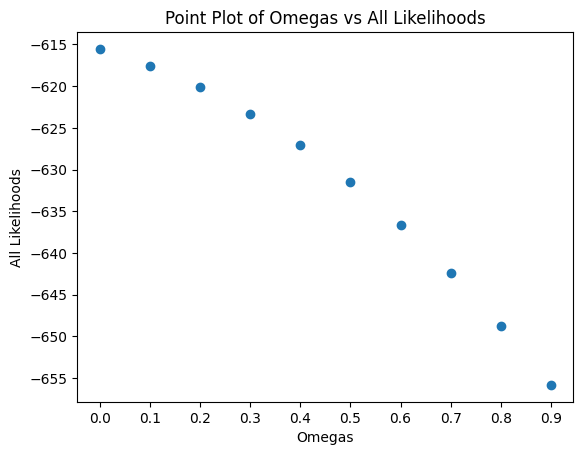

In [40]:
# Create the scatter plot
plt.scatter(omegas, all_likelihoods)

# Add labels and title
plt.xlabel('Omegas')
plt.ylabel('All Likelihoods')
plt.title('Point Plot of Omegas vs All Likelihoods')
plt.xticks(np.arange(0, 1, 0.1))
plt.show()